# ABOUT THIS NOTEBOOK
## Purpose
This notebook reruns the machine learning models used in implement_basic.ipynb, implement_nn.ipynb by including the gap values for the previous time slots as new features.    
Results of the model fitting are analyzed.
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of model fitting: plots, parameters and scores.
## Tasks Performed
* Load library packages
* Load pickle file
* Add gap values for previous time slots
* Split data into train & test sets
* Implement functions for common tasks
* Run the following algorithms:
    * Random Forest Regressor
    * K Nearest Neighbors
    * Support Vector Machines
    * Linear Regression
    * Gradient Boosting Regressor
    * Neural Nets
* For each of the algorithms perform the following:
    * Learning curve plots
    * Hyperparameter selection

# LOAD LIBRARY PACKAGES

In [1]:
# Import the required library packages
import os
import re
import timeit

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.contrib.learn as skflow

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.learning_curve import learning_curve
from sklearn.learning_curve import validation_curve
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, tensorflow sklearn & six'

Read in packages from os, numpy, pandas, matplotlib, seaborn, tensorflow sklearn & six


# LOAD PICKLE FILE

In [2]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [3]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# ADD GAP FOR PREVIOUS TIME SLOTS

In [4]:
# Create new gap features for previous 3 time slots
pdata_set['gap_t-1'] = (pdata_set['demand_t-1'] - pdata_set['supply_t-1'])
pdata_set['gap_t-2'] = (pdata_set['demand_t-2'] - pdata_set['supply_t-2'])
pdata_set['gap_t-3'] = (pdata_set['demand_t-3'] - pdata_set['supply_t-3'])

# SPLIT DATA INTO TRAIN & TEST SETS


## Use weeks 1 & 2 for training, week 3 for test

In [5]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 58) (66528, 58) 




## Generate scaled features for train & test sets

In [6]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3',
                  'gap_t-1', 'gap_t-2', 'gap_t-3'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

# IMPLEMENT FUNCTIONS FOR COMMON TASKS

## Scoring

In [7]:
# Generate Demand Supply Gap Metrics based on provided fit functions
# Assumes expected values for gap is in namesake column
def gap_estimate(**kwargs):
    """
    Generate scores for gap.
    
    Parameters
    ----------
    gX_train  : array containing train features
    gX_test   : array containing test features
    g_fitfunc : function to use for predicting
    """
    
    gX_train     = kwargs["gX_train"]
    gX_test      = kwargs["gX_test"]
    g_fitfunc    = kwargs["g_fitfunc"]
    
    print "\n\nGAP FORECASTING"
    print     "==============="

    # Generate predictions for train & test sets
    gy_pred_train    = target_scaler.inverse_transform(g_fitfunc.predict(gX_train))
    gy_pred_test     = target_scaler.inverse_transform(g_fitfunc.predict(gX_test))
   
    # Extract expected train & test values
    gy_train    = X_train['gap']
    gy_test     = X_test['gap']

    # Evaluate scores and print results
    print_score(gy_train, gy_pred_train, gy_test, gy_pred_test) 
    return

def print_score(y_train, y_pred_train, y_test, y_pred_test):
    
    """
    Present the MSE, R^2 and MAPE scores for train & test sets as a table.

    Parameters
    ----------
    y_train      : Array containing expected values for train set
    y_pred_train : Array containing predicted values for train set
    y_test       : Array containing expected values for test set
    y_pred_test  : Array containing predicted values for test set
    """
    
    m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
    m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


    r2score_train    = metrics.r2_score(y_train,    y_pred_train)
    r2score_test     = metrics.r2_score(y_test,     y_pred_test)

    # Assumes data is for 144 time slots, 14 days (train), 7 days (test)
    mpscore_train    = mape_score(y_train,    y_pred_train, ((144*14)-1))
    mpscore_test     = mape_score(y_test,     y_pred_test, ((144*7)-1))


    sets_list = ["TRAIN", "TEST"]

    m2_scores = [m2score_train, m2score_test]
    r2_scores = [r2score_train, r2score_test]
    mp_scores = [mpscore_train, mpscore_test]


    print '\t\tMEAN^2\t\tR2\t\tMAPE'

    for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
        print '{0:10}\t{1:.3f}\t\t{2:.3f}\t\t{3:.3f}' .format(s, m, r, mp)


def mape_score(exp, pred, q):
    
    """
    Generate the MAPE score value.

    Parameters
    ----------
    exp  : Array containing expected values
    pred : Array containing predicted values
    q    : Constant representing (number of days * number of time slots) - 1
    """
    
    mape = 0.0
    n = 66.0
    
    for gap, gapX in zip(exp, pred):
        if gap > 0:
            mape += 1.0 * abs((gap-gapX)/gap)
    return (mape/(n*q))

In [8]:
# Create a scorer function using the MAPE metric
# Use the training data size (144 time slots * 14 days) for q value

mape_scorer = make_scorer(mape_score, greater_is_better=False, q=((144*14)-1))

## Generate Learning Curves

In [9]:
def generate_learningcurves(sparse=False,**kwargs):
    ''' Generate learning curves by varying training sizes.
    Use Training vs Cross-validation curves.
    
    Arguments:
    gX_train -- Input features for training
    gy_train -- Target values for training
    alg -- Algorithm used for estimation
    alg_name -- Name of the algorithm
    
    Returns:
    Generates the learning curves plot.
    '''
   
    gX_train      = kwargs["gX_train"]
    gy_train      = kwargs["gy_train"]
    alg           = kwargs["alg"]
    alg_name      = kwargs["alg_name"]
    
    if (sparse):
        train_sizes = np.linspace(.01, 1.0, 6)
    else:
        train_sizes = np.linspace(.01, 1.0, 20)
    
    # Plot learning curve
    X, y = gX_train, gy_train
    title = 'Learning Curves for Gap (' + alg_name + ')'

    # Cross validation with 25 iterations to get smoother mean test and train
    # score curves, each time with 20% data randomly selected as a validation set.
    cv = cross_validation.ShuffleSplit(X.shape[0], n_iter=25, test_size=0.2, random_state=0)
    estimator = alg
    plot_learning_curve(estimator, alg_name, title, X, y, cv=cv, n_jobs=-1, train_sizes=train_sizes)
    plt.show()
    

        
def plot_learning_curve(estimator, alg_name, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curves.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
                An object of that type which is cloned for each validation.

    alg_name : name of the algorithm being tested
    
    title : string
            Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
           Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
         If an integer is passed, it is the number of folds (defaults to 3).
         Specific cross-validation objects can be passed, see
         sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
             Number of jobs to run in parallel (default 1).
             
    train_sizes : array, optional
                  Sizes of train set to use for generating the learning curve plot 
    """
    # Plot Learning Curve
    plt.figure(figsize=(15,8))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2 Score")
    

    start = timeit.default_timer()
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, 
                                                            n_jobs=n_jobs, train_sizes=train_sizes)
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'Learning Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s) 
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    
    
    # Print Scores
    for train_size, train_score, test_score in zip(train_sizes, train_scores_mean, test_scores_mean):
        print ('Train Size: {0:7d} Train Score: {1:.3f} Test Score: {2:.3f}' .format(int(train_size), float(train_score), float(test_score)))
    
    return plt


def conv_seconds(seconds):
    '''
    Convert seconds to hours, minutes, seconds format.
    '''
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)
    return (int(h),int(m),int(s))

## Select Hyperparameters

In [10]:
def select_hyperparams(**kwargs):
    ''' Perform hyperparameter selection using grid search with 5x2 cross validation.
    Generate learning curves, scores for the best estimator.
    
    Arguments:
    gX_train -- Input features for training
    gy_train -- Target values for training
    gX_test -- Input features for test
    gy_test -- Target values for test
    alg -- Algorithm used for estimation
    alg_name -- Name of the algorithm
    param_grid -- Dictionary with hyperparameters and their range
    scoring_func -- Scoring function for the algorithm
    
    Returns:
    Best estimator found by performing grid search.
    Generates the learning curves, scores for best estimator.
    '''
        
    gX_train      = kwargs['gX_train']
    gy_train      = kwargs['gy_train']
    gX_test       = kwargs["gX_test"]
    gy_test       = kwargs["gy_test"]

    
    alg           = kwargs['alg']
    alg_name      = kwargs['alg_name']
    param_grid    = kwargs['param_grid']
    scoring_func  = kwargs['scoring_func']
    
    start = timeit.default_timer()
    # Use nested cross validation - 5x2 cross validation
    g_gs = GridSearchCV(estimator=alg,
                  param_grid=param_grid,
                  scoring=scoring_func,
                  cv=2,
                  n_jobs=-1)
   
    scores = cross_val_score(estimator=g_gs,
                         X=gX_train,
                         y=gy_train,
                         scoring=scoring_func,
                         cv=5)

    g_gs = g_gs.fit(X=gX_train, y=gy_train)
    
    stop = timeit.default_timer()
    h, m, s = conv_seconds(stop - start)
    print 'GridSearchCV Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

    print 'All CV Scores:', scores
    print('Mean CV Score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
    print 'Best Estimator:\n', g_gs.best_estimator_

   
    # Generate Learning Curves
    generate_learningcurves(sparse=True, gX_train=gX_train, gy_train=gy_train,
                            alg=g_gs.best_estimator_, alg_name=alg_name)
    
    # Print All Scores   
    gap_estimate(gX_train=gX_train, gX_test=gX_test, g_fitfunc=g_gs)

# RANDOM FORESTS

GridSearchCV Runtime: 0h:17m:04s


All CV Scores: [ 0.86400109  0.86530154  0.79810496  0.63899784  0.08815592]
Mean CV Score: 0.651 +/- 0.293
Best Estimator:
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=12,
           max_features=1.0, max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=25, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)
Learning Curves Runtime: 0h:07m:41s


Train Size:    1064 Train Score: 0.713 Test Score: 0.504
Train Size:   22140 Train Score: 0.823 Test Score: 0.740
Train Size:   43216 Train Score: 0.850 Test Score: 0.782
Train Size:   64292 Train Score: 0.882 Test Score: 0.816
Train Size:   85368 Train Score: 0.905 Test Score: 0.837
Train Size:  106444 Train Score: 0.918 Test Score: 0.848


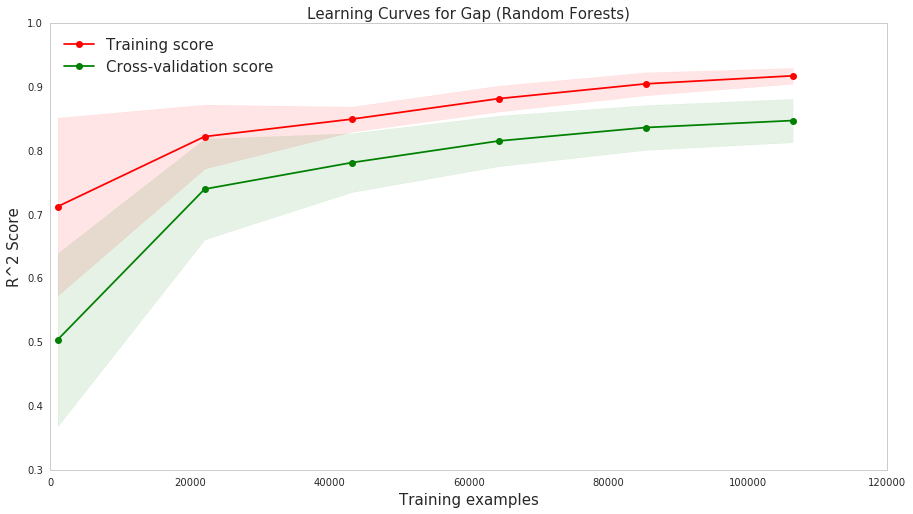



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	143.890		0.925		0.333
TEST      	303.481		0.869		0.347


In [13]:
rf_predictors = [0,3,1,5,2,8,4,19,25,26,27]

# Use GridSearchCV - RandomForestRegressor
# Specify parameters
param_grid = {'n_estimators'      : [300],
              'max_features'      : [1.0],
              'max_depth'         : [10, 11,12],
              'min_samples_split' : [15, 20, 25],
              'min_samples_leaf'  : [5, 6],
              'random_state'      : [0]}

alg = RandomForestRegressor()

# Only mse is supported for the RandomForestRegressor
# Use R^2 as scoring function for GridSearchCV, cross_val_score
select_hyperparams(gX_train=gX_train[:, rf_predictors], gy_train=gy_train, gX_test=gX_test[:, rf_predictors], gy_test=gy_test,
                   alg=alg, alg_name='Random Forests', param_grid=param_grid, scoring_func='r2')

# K NEAREST NEIGHBORS

GridSearchCV Runtime: 0h:00m:55s


All CV Scores: [ 0.8391034   0.83028641  0.75900276  0.56877969 -0.17503655]
Mean CV Score: 0.564 +/- 0.382
Best Estimator:
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
          metric_params=None, n_jobs=1, n_neighbors=7, p=2,
          weights='uniform')
Learning Curves Runtime: 0h:00m:58s


Train Size:    1064 Train Score: 0.671 Test Score: 0.481
Train Size:   22140 Train Score: 0.804 Test Score: 0.736
Train Size:   43216 Train Score: 0.833 Test Score: 0.778
Train Size:   64292 Train Score: 0.864 Test Score: 0.809
Train Size:   85368 Train Score: 0.881 Test Score: 0.821
Train Size:  106444 Train Score: 0.890 Test Score: 0.831


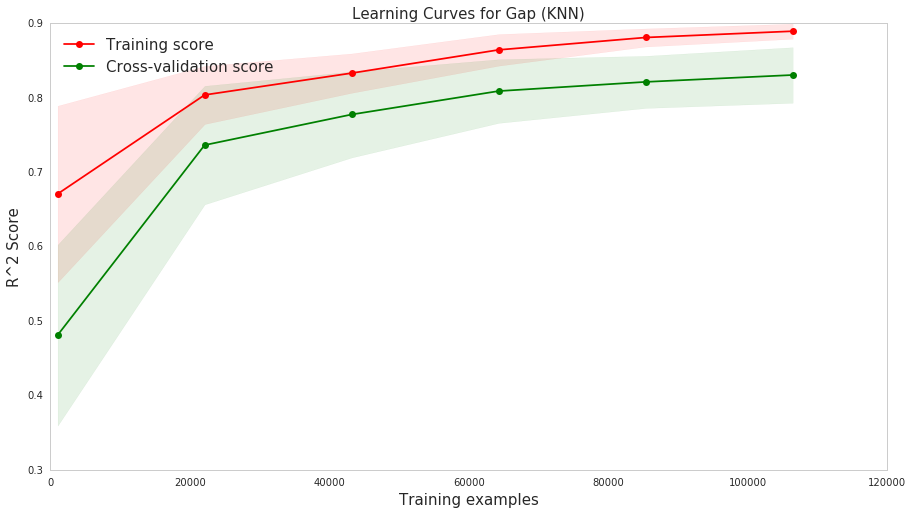



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	198.707		0.896		0.325
TEST      	344.498		0.851		0.384


In [14]:
knn_predictors = [0,3,1,5,2,8,4,19,25,26,27]

# Specify parameters
param_grid = {'n_neighbors' : [5, 6, 7],
              'weights'     : ['uniform'],
              'metric'      : ['euclidean', 'minkowski']}

alg = KNeighborsRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, knn_predictors], gy_train=gy_train, gX_test=gX_test[:, knn_predictors], gy_test=gy_test,
                   alg=alg, alg_name='KNN', param_grid=param_grid, scoring_func='r2')

# SUPPORT VECTOR MACHINES

In [ ]:
# Replace two of the demand, supply time slots with the new gap feature
# This is to reduce the runtime impact as the number of features increases
svm_predictors = [0,3,1,4,25,26]

# Specify parameters
param_grid = {'kernel'      : ['linear'],
              'C'           : [1.0],
              'epsilon'     : [0.1],
              'cache_size'  : [1000]  # to improve runtime
             }

alg = SVR()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, svm_predictors], gy_train=gy_train, gX_test=gX_test[:, svm_predictors], gy_test=gy_test,
                   alg=alg, alg_name='SVM', param_grid=param_grid, scoring_func='r2')

# LINEAR REGRESSION

GridSearchCV Runtime: 0h:00m:05s


All CV Scores: [-0.08231521 -0.07834414 -0.09599868 -0.23616007 -0.001021  ]
Mean CV Score: -0.099 +/- 0.076
Best Estimator:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Learning Curves Runtime: 0h:00m:08s


Train Size:    1064 Train Score: 0.890 Test Score: 0.848
Train Size:   22140 Train Score: 0.898 Test Score: 0.876
Train Size:   43216 Train Score: 0.895 Test Score: 0.878
Train Size:   64292 Train Score: 0.899 Test Score: 0.879
Train Size:   85368 Train Score: 0.900 Test Score: 0.879
Train Size:  106444 Train Score: 0.900 Test Score: 0.879


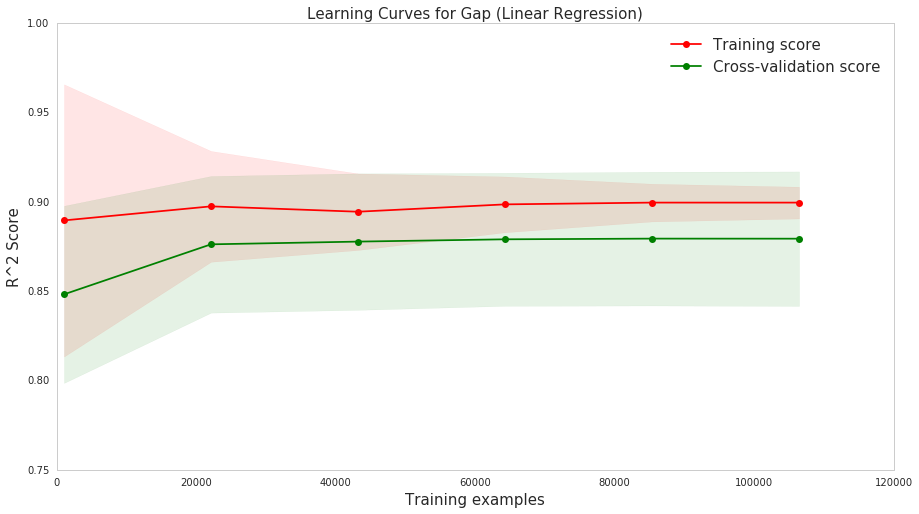



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	194.259		0.898		0.559
TEST      	313.566		0.864		0.541


In [15]:
linear_predictors = [0,3,2,4,25,26,27]

# No parameters to select
param_grid = {'fit_intercept'   : [True, False],
              'normalize'       : [True, False]
             }

alg = LinearRegression()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, linear_predictors], gy_train=gy_train, gX_test=gX_test[:, linear_predictors], gy_test=gy_test,
                   alg=alg, alg_name='Linear Regression', param_grid=param_grid, scoring_func='mean_squared_error')

# GRADIENT BOOSTED TREES

GridSearchCV Runtime: 0h:01m:20s


All CV Scores: [ 0.86035701  0.8725612   0.80065587  0.5903523   0.03928116]
Mean CV Score: 0.633 +/- 0.314
Best Estimator:
GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.15, loss='ls',
             max_depth=5, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=3, min_samples_split=8,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=0.8, verbose=0,
             warm_start=False)
Learning Curves Runtime: 0h:01m:56s


Train Size:    1064 Train Score: 0.995 Test Score: 0.260
Train Size:   22140 Train Score: 0.978 Test Score: 0.789
Train Size:   43216 Train Score: 0.974 Test Score: 0.836
Train Size:   64292 Train Score: 0.973 Test Score: 0.861
Train Size:   85368 Train Score: 0.970 Test Score: 0.865
Train Size:  106444 Train Score: 0.969 Test Score: 0.875


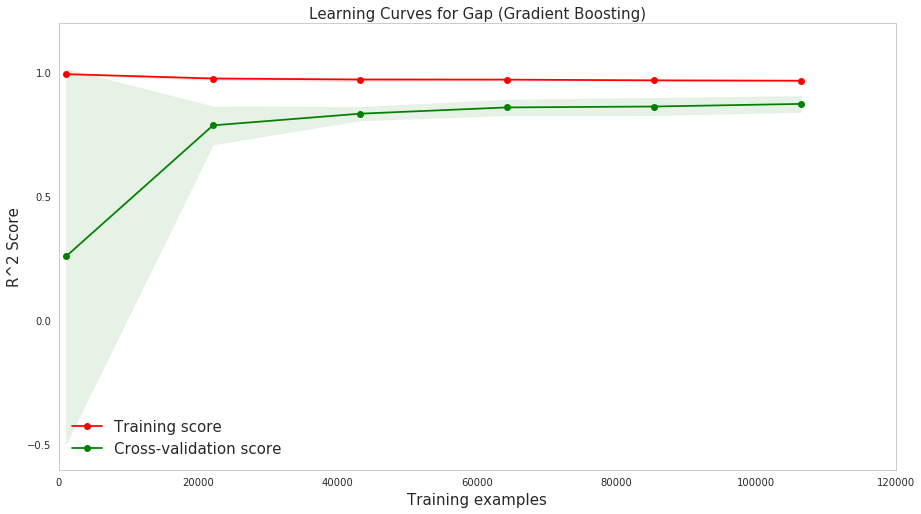



GAP FORECASTING
		MEAN^2		R2		MAPE
TRAIN     	62.551		0.967		0.344
TEST      	352.336		0.848		0.372


In [16]:
gbr_predictors = [0,3,2,1,20,9,5,19,25,26,27] 
# No parameters to select
param_grid = {'learning_rate'          : [0.15],
              'n_estimators'           : [100],
              'max_depth'              : [5],
              'min_samples_split'      : [7,8],
              'min_samples_leaf'       : [3],
              'subsample'              : [0.8]
             }

alg = GradientBoostingRegressor()

# Use R^2 as scoring function
select_hyperparams(gX_train=gX_train[:, gbr_predictors], gy_train=gy_train, gX_test=gX_test[:, gbr_predictors], 
                   gy_test=gy_test, alg=alg, alg_name='Gradient Boosting', param_grid=param_grid, scoring_func='r2')

# NEURAL NETS

In [ ]:
nn_predictors = [0,3,1,5,2,8,4,19,25,26,27]

# Set up optimizer, regressor
learning_rate=0.01 
hidden_units=[11] 
dropout=0.3 
steps=50000 
batch_size=3000

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
regressor = skflow.DNNRegressor(hidden_units=hidden_units, optimizer=optimizer, dropout=float(dropout))

# Fit
regressor.fit(gX_train[:, nn_predictors], gy_train, steps=steps, batch_size=batch_size)

# Predict and score
train_prediction = regressor.predict(gX_train[:, nn_predictors])
test_prediction  = regressor.predict(gX_test[:, nn_predictors])

print_score(gy_train, train_prediction, gy_test, test_prediction) 

		MEAN^2		R2		MAPE
TRAIN     	0.100		0.893		0.247
TEST      	0.162		0.856		0.252
